<a href="https://colab.research.google.com/github/M-Abbi/Financial-Modeling/blob/main/GLMs_with_practical_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Project: Loan Default Prediction using Generalized Linear Models (Logistic Regression)

## 1. Introduction to Generalized Linear Models (GLMs)

Generalized Linear Models (GLMs) are a flexible generalization of ordinary linear regression. They allow for response variables that have error distribution models other than a normal distribution.
A GLM consists of three components:
1.  **Random Component:** Identifies the probability distribution of the response variable (Y). Examples include Normal, Bernoulli, Poisson, Gamma.
2.  **Systematic Component (Linear Predictor):** Specifies the explanatory variables (X₁, X₂, ..., Xₚ) used in a linear predictor function: η = β₀ + β₁X₁ + ... + βₚXₚ.
3.  **Link Function (g):** Specifies the link between the random component (the expected value of Y, μ = E[Y]) and the systematic component (the linear predictor η). So, g(μ) = η.

## 2. Logistic Regression: A Specific GLM for Binary Outcomes

Logistic Regression is a GLM used when the response variable (Y) is binary (e.g., 0 or 1, Yes or No, Default or No Default).

*   **Random Component:** Bernoulli distribution. The outcome Y can be 0 or 1. E[Y] = p, where p is the probability of Y=1.
*   **Link Function:** Logit link. g(p) = ln(p / (1-p)). This is the natural logarithm of the odds.
*   **Systematic Component:** η = β₀ + β₁X₁ + ... + βₚXₚ.

So, for Logistic Regression:
ln(p / (1-p)) = β₀ + β₁X₁ + ... + βₚXₚ

This means the model predicts the log-odds of the event occurring. We can then convert this back to a probability:
p = 1 / (1 + exp(-η))

## 3. Simple Financial Example Application: Predicting Loan Default

**Problem:** A financial institution wants to predict the likelihood of a borrower defaulting on a loan based on certain characteristics.

**Objective:** Build a Logistic Regression model to estimate the probability of default.

**Features (Simplified & Synthetic):**
*   `credit_score`: A numerical score representing creditworthiness (e.g., 300-850). Higher is better - FICO score taken for inspiration.
*   `loan_to_income_ratio`: The ratio of the loan amount to the borrower's annual income. Higher might indicate more risk.
*   `employment_duration_years`: Number of years the borrower has been at their current job. Longer might indicate stability.

**Target Variable:**
*   `default_status`: Binary (1 if defaulted, 0 if not defaulted).

## 4. Model Implementation Steps

1.  **Data Preparation:**
    *   Load/Generate data.
    *   Handle missing values (if any, though we'll use synthetic data).
    *   Encode categorical variables (if any).
    *   Split data into training and testing sets.
    *   Feature Scaling (e.g., StandardScaler) can be beneficial for Logistic Regression, especially if regularization is used or features are on very different scales.
2.  **Model Training:**
    *   Instantiate a Logistic Regression model.
    *   Train the model using the training data (X_train, y_train).
3.  **Model Evaluation:**
    *   Make predictions on the test set (X_test).
    *   Evaluate performance using metrics like:
        *   Accuracy
        *   Precision, Recall, F1-score (especially for imbalanced datasets)
        *   Confusion Matrix
        *   ROC Curve and AUC (Area Under the Curve)
4.  **Coefficient Interpretation:**
    *   Examine the model coefficients (β values).
    *   The sign of a coefficient indicates the direction of the relationship (positive or negative) between the feature and the log-odds of default.
    *   The magnitude, when exponentiated (exp(β)), gives the odds ratio. For a one-unit increase in Xᵢ, the odds of default are multiplied by exp(βᵢ), holding other variables constant.

## 5. Assumptions of Logistic Regression

*   **Binary Outcome:** The dependent variable must be binary.
*   **Independence of Observations:** Observations should be independent of each other.
*   **Linearity of Logit:** The relationship between the logit of the outcome and each continuous independent variable is linear.
*   **No Severe Multicollinearity:** Independent variables should not be too highly correlated with each other.
*   **Large Sample Size:** Logistic regression typically requires a larger sample size than OLS regression for stable estimates.

---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

1.  **Data Preparation - General Steps:**
    *   Load/Generate data.
    *   Handle missing values (if any, though we'll use synthetic data).
    *   Encode categorical variables (if any).
    *   Split data into training and testing sets.
    *   Feature Scaling (e.g., StandardScaler) can be beneficial for Logistic Regression, especially if regularization is used or features are on very different scales.
    * I ALWAYS want to plot the data to check them visually.

In [ ]:
# --- 1. Data Generation (Synthetic Financial Data for Loan Default) ---
np.random.seed(42) # for reproducibility
num_samples = 1000

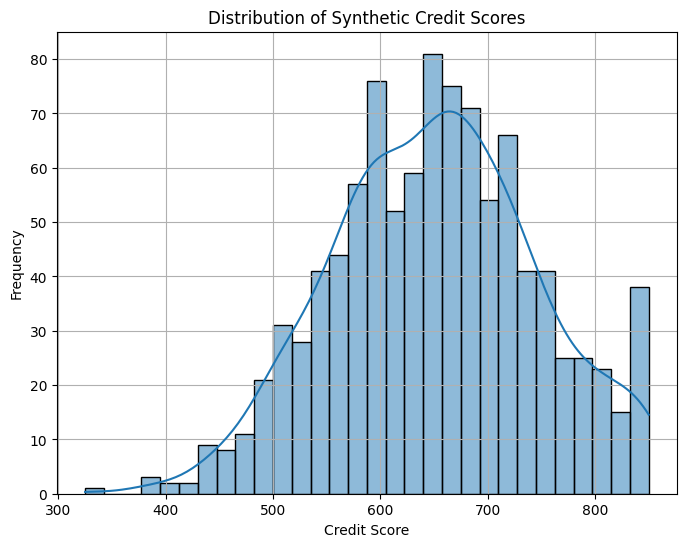

In [ ]:
# Feature 1: Credit Score (higher is better, less likely to default)
# Let's assume scores are somewhat normally distributed, centered around 650
credit_score = np.random.normal(loc=650, scale=100, size=num_samples).astype(int)
credit_score = np.clip(credit_score, 300, 850) # Clip to a realistic range

# Plotting the Credit Score distribution
plt.figure(figsize=(8, 6))
sns.histplot(credit_score, bins=30, kde=True)
plt.title('Distribution of Synthetic Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

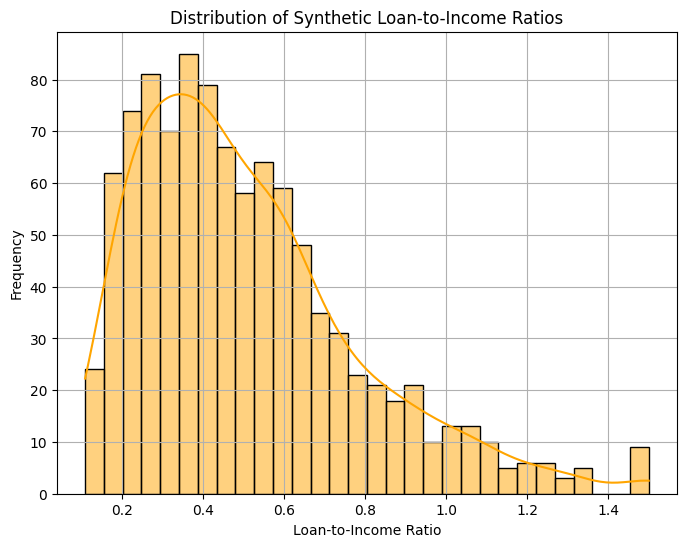

In [ ]:
# Feature 2: Loan-to-Income Ratio (LTI) (higher ratio, more likely to default)
# Let's assume LTI is somewhat log-normally distributed or gamma-like
lti_ratio = np.random.gamma(shape=2, scale=0.2, size=num_samples) + 0.1 # Avoid zero
lti_ratio = np.clip(lti_ratio, 0.1, 1.5) # Realistic range, 10% to 150%

# Plotting the LTI Ratio distribution
plt.figure(figsize=(8, 6))
sns.histplot(lti_ratio, bins=30, kde=True, color='orange')
plt.title('Distribution of Synthetic Loan-to-Income Ratios')
plt.xlabel('Loan-to-Income Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

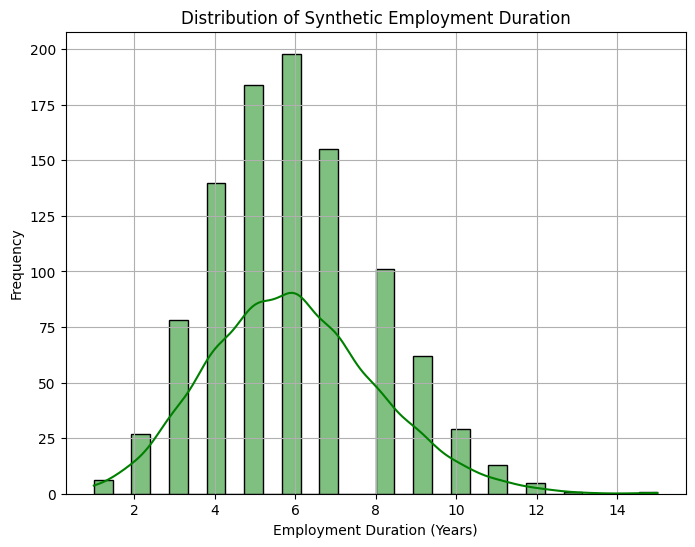

In [ ]:
# Feature 3: Employment Duration (years) (longer duration, less likely to default)
employment_duration = np.random.poisson(lam=5, size=num_samples) + 1 # Min 1 year
employment_duration = np.clip(employment_duration, 1, 30)

# Plotting the Employment Duration distribution
plt.figure(figsize=(8, 6))
sns.histplot(employment_duration, bins=30, kde=True, color='green')
plt.title('Distribution of Synthetic Employment Duration')
plt.xlabel('Employment Duration (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 1. Create the target variable 'default_status' based on a logistic function

Let's define the log-odds function based on the features introduced:

log_odds = intercept + β1 * *credit_score* + β2 * *lti_ratio* + β3 *
*employment_duration*

And we want:
 - Higher credit score -> lower log_odds (negative β1)
 - Higher LTI ratio -> higher log_odds (positive β2)
 - Higher employment duration -> lower log_odds (negative β3)

 ---

To compare the different distributions we standardize them (standardizing a distribution transforms it to have a mean of 0 and a standard deviation of 1) with the following:

We subtract the original mean (μ) from each data point (x) and then divide by the original standard deviation (σ).

This process converts the original data point x to a z-score:
z = (x - μ) / σ

In [ ]:
# Initiation of coefficients with arbitrary values for generating data (these are NOT the model's learned coefficients)
intercept_true = -2.0
beta_credit_score_true = -0.01
beta_lti_true = 2.5
beta_employment_true = -0.15

log_odds = (intercept_true +
            beta_credit_score_true * ((credit_score - np.mean(credit_score)) / np.std(credit_score)) +
            beta_lti_true * ((lti_ratio - np.mean(lti_ratio)) / np.std(lti_ratio)) +
            beta_employment_true * ((employment_duration - np.mean(employment_duration)) / np.std(employment_duration)))

# Convert log-odds to probability
probabilities = 1 / (1 + np.exp(-log_odds))

# Generate binary default status based on these probabilities - introduces some randomness, simulating that even with the same characteristics, not all borrowers will behave identically
default_status = np.random.binomial(1, probabilities)

# Create DataFrame
df = pd.DataFrame({
    'credit_score': credit_score,
    'lti_ratio': lti_ratio,
    'employment_duration_years': employment_duration,
    'default_status': default_status
})

print("--- Synthetic Data Head ---")
print(df.head())
print("\n--- Default Status Distribution ---")
print(df['default_status'].value_counts(normalize=True))

--- Synthetic Data Head ---
   credit_score  lti_ratio  employment_duration_years  default_status
0           699   0.940914                          6               1
1           636   0.733605                          7               1
2           714   0.448968                          5               1
3           802   0.292643                          7               0
4           626   0.722012                          5               1

--- Default Status Distribution ---
default_status
0    0.778
1    0.222
Name: proportion, dtype: float64


# 2. Data Preparation

1.   We split data into training and testing sets.
2.   We create an instance of StandardScaler, which standardizes features by removing the mean and scaling to unit variance (making the mean 0 and the standard deviation 1).

In [ ]:
# --- Data Preparation ---
X = df[['credit_score', 'lti_ratio', 'employment_duration_years']]
y = df['default_status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# stratify = y ensures that the percentage of each class in y (the percentage of 0 and 1) is maintained in both the resulting training (y_train) and testing (y_test) subsets.

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # calculates the mean and standard deviation from the training data (X_train) and then applies the transformation to X_train. It's important to fit only on the training data to avoid data leakage from the test set.
X_test_scaled = scaler.transform(X_test) # applies the same learned mean and standard deviation from the training data to the test data (X_test). We use transform here, not fit_transform, to ensure the test data is scaled based on the training data's characteristics.

# Convert scaled arrays back to DataFrames for easier coefficient interpretation later
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 3. Model Training (Logistic Regression)

The algorith 'liblinear' tells the scikit-learn library how to find the best coefficients (the β values) for the Logistic Regression model.

Goal of the algorithm: minimize the error between the model's predictions and the actual target values during training.

In [ ]:
# --- Model Training ---
# For GLM understanding, we use LogisticRegression from sklearn
# C is the inverse of regularization strength; smaller C means stronger regularization.
# penalty='l2 ' (Ridge - adds a penalty based on the square of the coefficient values). 'none' can be used if no regularization is desired.
# solver='liblinear' is good for smaller datasets and supports L1/L2. 'lbfgs' is often default.
model = LogisticRegression(solver='liblinear', random_state=42, C=1.0, penalty='l2')
model.fit(X_train_scaled_df, y_train)

print("\n--- Model Trained ---")


--- Model Trained ---


**Quick introduction to regularization:**

When training a machine learning model, especially with many features, there's a risk of overfitting. Overfitting means the model learns the training data too well, including the noise and specific patterns that aren't representative of new, unseen data. An overfit model will perform poorly on test data even if it performs perfectly on training data.

Regularization is a technique used to prevent overfitting by adding a penalty to the model's complexity. This penalty is added to the cost function (the function the model tries to minimize during training). By penalizing complexity, the model is encouraged to find simpler solutions that generalize better to new data.

The code uses the penalty='l2' parameter in the LogisticRegression constructor:

model = LogisticRegression(solver='liblinear', random_state=42, C=1.0, penalty='l2')
Use code with caution
Here's a brief explanation of L1 and L2 penalties:

1.   L2 Regularization (Ridge Regularization): How it works: It adds a penalty proportional to the square of the magnitude of the coefficients (β values). The penalty term is λ * Σ(βᵢ)², where λ is a tuning parameter (related to C in scikit-learn, where C = 1/λ).
Effect: This penalty encourages the model to keep the coefficients small. It tends to shrink the coefficients towards zero, but it rarely forces them exactly to zero. All features will likely still have a small influence on the model.
Benefit: Helps to reduce the impact of less important features and makes the model less sensitive to small variations in the training data.
2.   L1 Regularization (Lasso Regularization): How it works: It adds a penalty proportional to the absolute value of the magnitude of the coefficients (β values). The penalty term is λ * Σ|βᵢ|.
Effect: This penalty also encourages small coefficients, but it has a property of driving the coefficients of less important features exactly to zero.
Benefit: This can be useful for feature selection, as it effectively removes features with zero coefficients from the model. This can lead to a sparser model (a model with fewer features actively contributing).


In Summary:



1.   L2 (Ridge): Shrinks coefficients towards zero, but rarely to exactly zero. Good for preventing overfitting by reducing the overall impact of features.
2.   L1 (Lasso): Shrinks coefficients towards zero and can set less important ones exactly to zero. Good for preventing overfitting and performing automatic feature selection.
The code uses penalty='l2', meaning it applies Ridge regularization to help keep the model's coefficients from becoming too large and thus prevent overfitting on the synthetic training data. The strength of this penalty is controlled by the C parameter (inverse of the regularization strength).


# 4. Model Evaluation

We evaluate how well the data predicted by the Logistic Regression model performs against the test set.

This is a crucial step to understand if the model has learned general patterns or if it has simply memorized the training data (overfitting).

In [ ]:
# --- Model Evaluation ---
y_pred_test = model.predict(X_test_scaled_df)
y_pred_proba_test = model.predict_proba(X_test_scaled_df)[:, 1] # We select probabilities for the positive class (default=1)

# These probabilities give us a better understanding of the model's confidence in its prediction, not just a simple 1 - 0 outcome.

print("\n--- Model Evaluation on Test Set ---")


--- Model Evaluation on Test Set ---


**Accuracy**

- True Negatives (TN): The number of instances where the model correctly predicted the negative class ('No Default').
- False Positives (FP): The number of instances where the model incorrectly predicted the positive class ('Default') when the actual class was negative ('No Default'). This is also known as a Type I error.
- False Negatives (FN): The number of instances where the model incorrectly predicted the negative class ('No Default') when the actual class was positive ('Default'). This is also known as a Type II error.
- True Positives (TP): The number of instances where the model correctly predicted the positive class ('Default').

$$ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} $$

In [ ]:
# Accuracy

accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9000


**The structure of the confusion matrix cm is typically:**

[ [True Negatives (TN), False Positives (FP)]

  [False Negatives (FN), True Positives (TP)] ]



Confusion Matrix:
[[189   6]
 [ 19  36]]


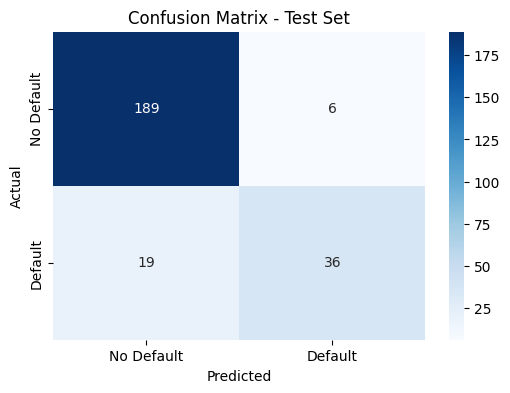

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

**Recall (or Sensitivity)**: This metric answers the question: "Of all the instances that were actually positive, how many did the model correctly identify as positive?" It is calculated as: $$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

**F1-Score**: This is the harmonic mean of Precision and Recall. The harmonic mean is used because it penalizes extreme values. A high F1-score means the model has high precision and high recall. It is calculated as: $$ \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

In [ ]:
# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['No Default (0)', 'Default (1)']))


Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.91      0.97      0.94       195
   Default (1)       0.86      0.65      0.74        55

      accuracy                           0.90       250
     macro avg       0.88      0.81      0.84       250
  weighted avg       0.90      0.90      0.89       250



In [ ]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9223


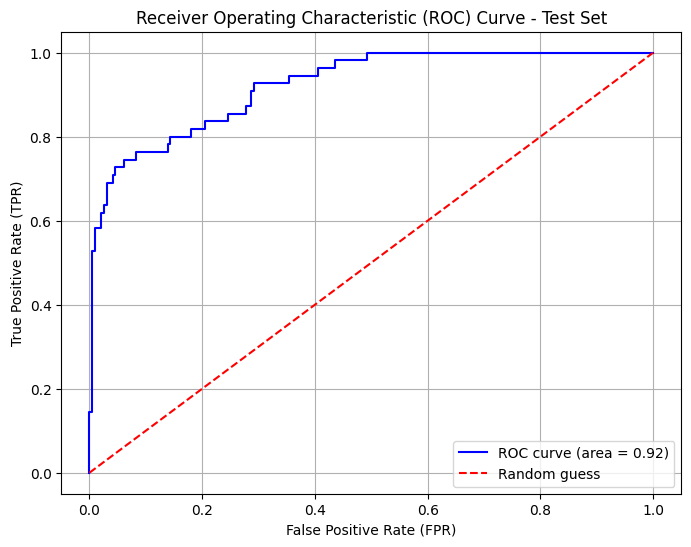

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 5. Coefficient Interpretation ---
print("\n--- Model Coefficients ---")
print(f"Intercept (β₀): {model.intercept_[0]:.4f}")

coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient (β)': model.coef_[0]
})
coefficients['Odds_Ratio (exp(β))'] = np.exp(coefficients['Coefficient (β)'])
print(coefficients)

print("\nInterpreting Coefficients (for scaled features):")
print("- Intercept: The log-odds of default when all scaled features are zero (i.e., at their mean values).")
for index, row in coefficients.iterrows():
    feature_name = row['Feature']
    coeff_val = row['Coefficient (β)']
    odds_ratio = row['Odds_Ratio (exp(β))']

    interpretation = ""
    if coeff_val > 0:
        interpretation = f"a one-unit increase in the scaled '{feature_name}' is associated with an increase in the log-odds of default by {coeff_val:.4f}. The odds of default are multiplied by {odds_ratio:.4f}."
    else:
        interpretation = f"a one-unit increase in the scaled '{feature_name}' is associated with a decrease in the log-odds of default by {abs(coeff_val):.4f}. The odds of default are multiplied by {odds_ratio:.4f} (i.e., divided by {1/odds_ratio:.4f})."
    print(f"- {feature_name}: {interpretation}")

print("\nNote: Coefficients are for *scaled* features. A one-unit increase in a scaled feature corresponds to a one standard deviation increase in the original feature's value from its mean.")


--- Model Coefficients ---
Intercept (β₀): -1.9577
                     Feature  Coefficient (β)  Odds_Ratio (exp(β))
0               credit_score        -0.104710             0.900586
1                  lti_ratio         2.249957             9.487324
2  employment_duration_years        -0.189283             0.827552

Interpreting Coefficients (for scaled features):
- Intercept: The log-odds of default when all scaled features are zero (i.e., at their mean values).
- credit_score: a one-unit increase in the scaled 'credit_score' is associated with a decrease in the log-odds of default by 0.1047. The odds of default are multiplied by 0.9006 (i.e., divided by 1.1104).
- lti_ratio: a one-unit increase in the scaled 'lti_ratio' is associated with an increase in the log-odds of default by 2.2500. The odds of default are multiplied by 9.4873.
- employment_duration_years: a one-unit increase in the scaled 'employment_duration_years' is associated with a decrease in the log-odds of default by

In [ ]:
# --- (Optional) Further Analysis: Statsmodels for more detailed GLM summary ---
import statsmodels.api as sm

# Add constant for intercept term for statsmodels
X_train_scaled_sm = sm.add_constant(X_train_scaled_df, has_constant='add') # 'has_constant' can be explicit

# Fit GLM (Logistic Regression) using statsmodels
# family=sm.families.Binomial() specifies the Bernoulli distribution and logit link
glm_model = sm.GLM(y_train, X_train_scaled_sm, family=sm.families.Binomial())
glm_results = glm_model.fit()

print("\n\n--- Statsmodels GLM Summary ---")
print(glm_results.summary())
print("\nThis summary provides p-values for coefficients, confidence intervals, and other useful statistics.")

ValueError: The indices for endog and exog are not aligned